DSN Dec 1, 2021

Network games on a real-world social network that you can play with to test different conditions. 

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# Networkx (a python package)
Provides nice ways to draw networks. Nodes are connected by edges.

One way to draw networks is to make the connected nodes closer together. This is called the "spring" layout because it pretends edges are connected like springs.

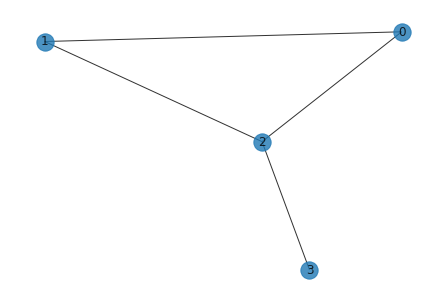

In [2]:
# Simple network with 4 nodes

G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 0)
G.add_edge(2, 3)

nx.draw(G, 
        alpha=0.8,        # a little transparent
        with_labels=True) # label nodes with numbers

## DIY 1
Try adding some edges to this network.

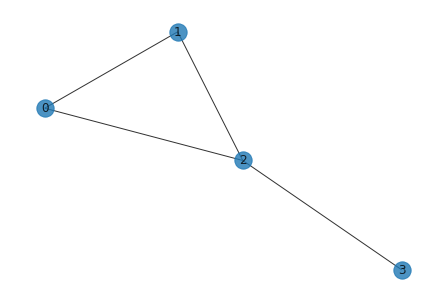

In [3]:
# Hint: Adding an edge between 0 and 3 is
# G.add_edge(0, 3)

# Your code here

nx.draw(G, 
        alpha=0.8,        # a little transparent
        with_labels=True) # label nodes with numbers

# Game theory on a network

Start with a very simple network with only 2 people.

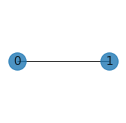

In [4]:
G = nx.Graph()
G.add_edge(0, 1)

# position is a dictionary, {word1: meaning1, word2: meaning2}
# for networkx, the "word" is the "node number"
# and the "meaning" is the "[x,y] position" 
pos = {0:[0,0], 1:[1, 0]}  # a horizontal line

fig, ax = plt.subplots(figsize=[2, 2])
nx.draw(G,
        alpha=0.8,         # a little transparent
        with_labels=True,  # label nodes with numbers
        pos=pos,           # position
        ax=ax)             # where to draw
plt.show()

## Prisoner's dilemma
Pretend 2 people are playing a game. In each round of the game, each person can decide to cheat (be a defector) or to play fairly (be a collaborator). 

### Points
- Both collaborate: Both players win pts_CC=1 point.
- Both defect: No-one gest any points (pts_DD=0)
- Player 0 defects: Player 0 gets pts_DC=1.5 points. Player 1 gets nothing.
- Player 1 defects: Player 0 gets nothing. Player 1 gets pts_DC1.5 points. 

### What to do next round
- Each player looks at neighbors' points
- Copy the strategy of the neighbor with the highest points
- (Or keep your own strategy if you beat your neighbors)

## Labeling defectors on the network

In [5]:
# Use the role to draw defectors
def draw_defectors(G, role, pos=None, sizes=None, color_C='lightblue', color_D='pink'):
    """
    Show which people are defectors vs collaborators
    Inputs:
    -------
        G (networkx graph)
        role (np array): index is node number, 1=defector, 0=collaborator
        
        Optional keyword arguments
        pos (dict): with keys=nodes, values=xyz positions
        sizes (np array): circle size
        color_C (string): color of collaborator
        color_D (string): color of defector
    No outputs
    """
    colors = []
    for v in G.nodes():
        if role[v] == 1:  
            color = color_D  # defector
        else:
            color = color_C  # collaborator
        colors.append(color)
    # size of circles
    if sizes is None:
        sizes = 200*np.ones(G.number_of_nodes())
    nx.draw(G, pos=pos, with_labels=True, 
            node_color=colors, 
            alpha=0.8, 
            node_size=sizes)
    plt.show()
    pass

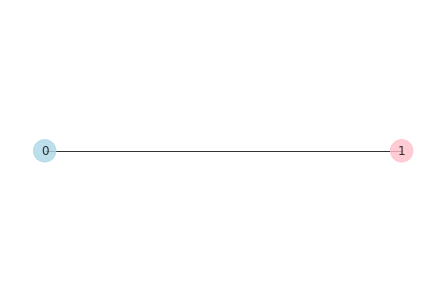

Player 0 is a collaborator (blue).
Player 1 is a defector (pink)


In [6]:
# Make player 0 a collaborator and player 1 a defector
roles = np.array([0, 1])
draw_defectors(G, roles, pos=pos, sizes=[500, 500])

print('Player 0 is a collaborator (blue).')
print('Player 1 is a defector (pink)')

## Get points by playing the game

In [7]:
def get_points(G, role, pts_DD=0, pts_DC=1.5, pts_CC=1):
    """Return points after a round of Prisoner's Dilemma on
    on a network. Only people connec by an edge can play
    against each other. 
    
    Inputs:
    ------
        G (networkx graph)
        role (np array): 0=collaborator, 1=defector. 
        pts should all be positive
    Sum of each pair of people.
    Rules:
        - sum=2 -> both lose     -> each gets pts_DD
        - sum=1 -> defector wins -> defector gets pts_DC
        - sum=0 -> both win      -> each gets pts_CC
    """
    points = np.zeros(G.number_of_nodes())
    edge_list = list(G.edges()) 
    for edge in edge_list:
        i, j = edge                   # persons i and j
        role_edge = role[list(edge)]  # defector=1 or collaborator=0?
        sum_edge = sum(role_edge)     # sum of each pair of people
        # examine interaction based on sum 
        if sum_edge == 0:
            points[i] += pts_CC  # both collaboration
            points[j] += pts_CC
        elif sum_edge == 2:
            points[i] += pts_DD
            points[j] += pts_DD  # both defect
        else:
            if role[i] == 1: # i is defector
                points[i] += pts_DC
            else:            # j is defector
                points[j] += pts_DC
    return points

Player 0 (collaborator, role=0) has 0.0 points.
Player 1 (defector, role=1) has 1.5 points.


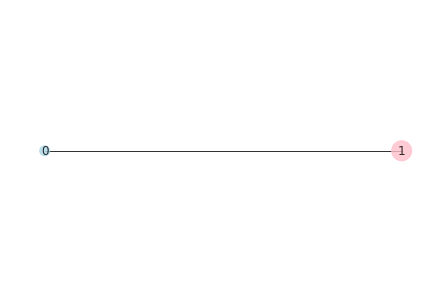

Player 1 is winning (larger circle).


In [10]:
# get points after one round of the game where player 1
# cheats player 0
points = get_points(G, roles, pts_DC=1.5)
print(f'Player 0 (collaborator, role={roles[0]}) has {points[0]} points.')
print(f'Player 1 (defector, role={roles[1]}) has {points[1]} points.')

draw_defectors(G, 
               roles,  # 1=defector=pink, 0=collaborator=blue 
               pos=pos,  # xy position
               sizes=(100+points*200))  # circle size

print('Player 1 is winning (larger circle).')

## Choose strategy for next round

In [22]:
def get_new_mutrole(G, role, points, p_m=0):
    """
    Return the strategy in the next round.
    Adopt the strategy of whoever is winning of your neighbors. 
    If you beat all your neighbors, keep your strategy. Make an
    error in your calculations at rate p_m.
    
    Inputs:
    ------
        G (networkx graph)
        role (np array): 0=collaborator, 1=defector. 
        points (np array): score, not normalized
        p_m (double): probability of error
    """
    print(f'Role error rate is p_m = {p_m}')
    new_role = np.zeros(len(role))
    for player in range(G.number_of_nodes()):
        # Get node numbers for self+neighbors
        n_list = [n for n in G.neighbors(player)]
        n_list.append(player)
        # For self+neighbors, get points and roles
        n_pts = points[n_list]  # points
        n_roles = role[n_list]  # defector or collaborator roles
        #
        # identify a winner
        max_pts = max(n_pts)
        all_winners_index = np.argwhere(n_pts==max_pts).flatten()
        all_winners_players = np.array(n_list)[all_winners_index]
        all_winners_roles = n_roles[all_winners_index]
        # select 1 winner
        # winner = np.random.choice(all_winners_players)
        winner = all_winners_players[0]  # choose self
        winner_role = role[winner]
        # add randomness 
        if np.random.rand() < p_m:
            new_role[player] = (winner_role + 1) % 2
        else:
            new_role[player] = winner_role 
    return new_role

In [26]:
# Get new roles based on points
new_roles = get_new_mutrole(G, roles, points)

Role error rate is p_m = 0


Previous round


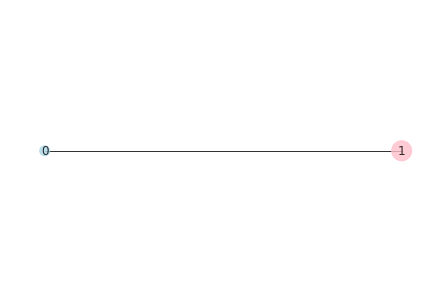

Roles in next round
Player 0 will be a defector in the next round.
Player 1 remains a defector


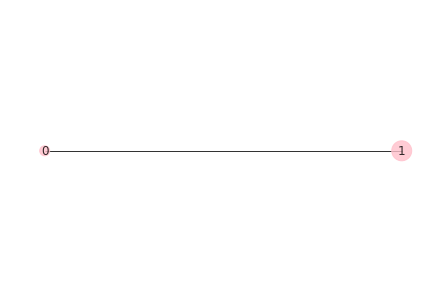

In [27]:
print('Previous round')
draw_defectors(G, 
               roles,  # old role
               pos=pos,  # xy position
               sizes=(100+points*200))  # circle size

print('Roles in next round')
print('Player 0 will be a defector in the next round.')
print('Player 1 remains a defector')
draw_defectors(G, 
               new_roles,  # new role 
               pos=pos,  # xy position
               sizes=(100+points*200))  # circle size



In [59]:
# Randomly assign one player to be a defector
N = G.number_of_nodes()
num_D = 1
roles = np.zeros(N)  # initialize all collaborators as 0
ind_Ds = np.random.choice(range(N), num_D)  # defectors
roles[ind_Ds] = 1  # set defectors to 1



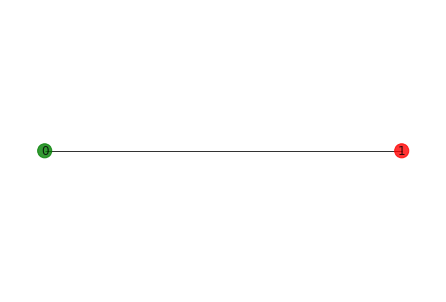

In [61]:
draw_defectors(G, roles, pos=pos)

# The network
In the 70s, the 34 people in a karate club had a schism and separated (described by Wayne Zachary). Network scientists wanted to see whether the social network could explain which friendships were lost in the schism.

More information: https://en.wikipedia.org/wiki/Zachary%27s_karate_club

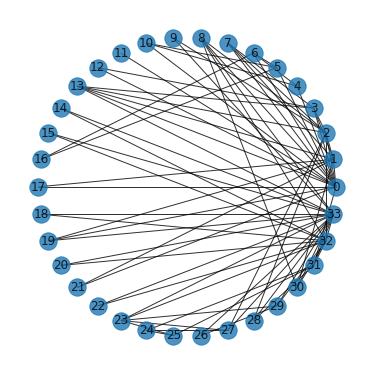

In [7]:
# Load the network
G = nx.karate_club_graph()

# Draw the network
plt.figure(figsize=[5, 5])
nx.draw_circular(G, 
                 alpha=0.8,         # slightly transparent
                 with_labels=True)  # number the nodes
plt.show()